In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from kmodes.kprototypes import KPrototypes
from scipy.optimize import curve_fit
import seaborn as sns



# Dades de consum. Processades i clusteritzades

    - El fitxer de dades conté 20 columnes i 2.444.832 files (interaccions o unitats de consum).
    - El fitxer s'ha processat i netejat i s'ha realitzat el clustering, utilitzant l'algoritme K-Prototypes.
    - L'ultima columna "Segment" correspon a l'etiqueta del clústes. És a dir, a quin clúster pertany cada consum (C1...).
    - Les 19 columnes restants caracteritzen les unitats de consum:
        - min_data:  hora inici reproducció
        - durada_consum: durada del consum
        - durada: durada del videoclip consumit
        - usuari_id: identificador de l'usuari logat
        - player_id: identificador de la reproducció
        - producte_id: plataforma des de la qual s'ha consumit (PortalCCMA, appTV3...)
        - contingut_id: identificador del contingut
        - canal_nom: nom del canal
        - programa_nom: nom del programa
        - programa_capitol: capitol (1,2,3...)
        - tematica: tematica del programa (mal informada)
        - dispositiu_accepta_cookies: si accepta o no cookies
        - dispositiu_model: model del dispositiu
        - dispositiu_vendor: marca del dispositiu
        - dispositiu_browser_nom: navegador utilitzat
        - dispositiu_tipus: tipus de dispositiu
        - year: any de consum  
        - day: dia de la setmana del consum
        - month: mes de l'any del consum
        

# INDEX

### 1- Estadística de les dades
    1.1- Hora d'inici de la reproducció
    1.2- Durada del consum
    1.3- Durada del videoclip
    1.4- Usuaris registrats
    1.5- Dimensions discretes: dispositiu, programa, dia, mes...
    
    
    
### 2- Resultats del clustering (K-Prototypes mixed data)
    2.1- Hora d'inici de la reproducció
    2.2- Durada del consum
    2.3- Durada del videoclip
    2.4- Mes de l'any
    2.5- Dia de la setmana
    2.6- Any
    2.7- Producte consumit
    2.8- Tipus de dispositiu
    2.9- Canal
    2.10- Valors únics en cada clúster
    2.11- Evolució dels clústers per any
    
### 3- Cross validation score i SHAP Value. LightGMB (machine learning)
    3.1- Cross validation score
    3.2- SHAP value
    
    
       

In [2]:
df = pd.read_csv('dades_consum_cluster.csv')   # Llegim el fitxer de dades
df = df.fillna('nan') # NaN values to strings
df['year']=df['year'].astype(str) # to string 
df

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,min_data,durada_consum,durada,usuari_id,player_id,producte_id,contingut_id,canal_nom,programa_nom,programa_capitol,tematica,dispositiu_accepta_cookies,dispositiu_model,dispositiu_vendor,dispositiu_browser_nom,dispositiu_tipus,year,day,month,Segment
0,72083.0,224.0,3425.0,cd59b5d0eadd11e78b917b6a96b37d13,532431546297264625,PortalCCMA,5808597,TV3,Howards End,4.0,FICCIÓ,True,ANDROID,nan,CHROME,TABLET,2019,Tuesday,January,C3
1,72170.0,936.0,2760.0,ef3a5e305a3011e8b2856b1b1792d2d5,151871546297352716,PortalCCMA,5809807,TV3,Telenotícies,5214.0,ACTUALITAT,True,ANDROID,nan,CHROME,MOBILE,2019,Tuesday,January,C3
2,72283.0,6821.0,5825.0,971bc1a0d61711e7997557f16f7e845d,94429,appMobil_tv3,5808127,TV3,Pel·lícules,1.0,FICCIÓ,True,ANDROID,HUAWEI,ANDROID BROWSER,MOBILE,2019,Tuesday,January,C4
3,72288.0,0.0,49.0,58169d60b60c11e885daa1c496d066bd,16755,appMobil_tv3,5809111,TV3,TV3,nan,PROMOCIÓ CADENA,True,ANDROID,nan,CHROME,MOBILE,2019,Tuesday,January,C3
4,72329.0,0.0,49.0,7c5460400d5011e9b7c3ab71693993b0,81949,appMobil_tv3,5809111,TV3,TV3,nan,PROMOCIÓ CADENA,False,ANDROID,nan,CHROME,MOBILE,2019,Tuesday,January,C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444828,70036.0,60.0,95.0,b8cb5320da4a11eb971ae3fd86aee49d,829171632259572094,PortalCCMA,6120002,TV3,Telenotícies comarques,5795.0,ACTUALITAT,True,ANDROID,nan,CHROME,MOBILE,2021,Tuesday,September,C3
2444829,70038.0,0.0,2757.0,88d72a800bda11eabdcfd32cdc687e54,835391632259631354,appTV_tv3,6118323,TV3,Crims,22.0,DIVULGACIÓ,True,UE43RU7405UXXC,SAMSUNG,SAFARI,TV,2021,Tuesday,September,C3
2444830,70040.0,27.0,29.0,30b501201b1311eca51e3d25c93f171e,541771632259650113,PortalCCMA,6120006,TV3,Notícies 3/24,6569.0,MÓN,False,WINDOWS,nan,CHROME,PC,2021,Tuesday,September,C3
2444831,70063.0,120.0,2757.0,db8526d01b2111ecbee3a178ccf276eb,892101632259411606,appMobil_tv3,6118323,TV3,Crims,22.0,DIVULGACIÓ,False,ANDROID,nan,CHROME,MOBILE,2021,Tuesday,September,C3


# 1- Estadística de les dades

## 1.1- Hora d'inici de la reproducció

Representem la pdf normalitzada (densitat sota de la corva = 1) de l'hora d'inici del consum.

    - Utilitzem caixes de 5 minuts (300s). 
    - Hem realitat un shift per realitzar els càlculs i el clustering de 4h, per posar l'origen on el consum és mínim. 
      Desfem el shift per representar la pdf.
    

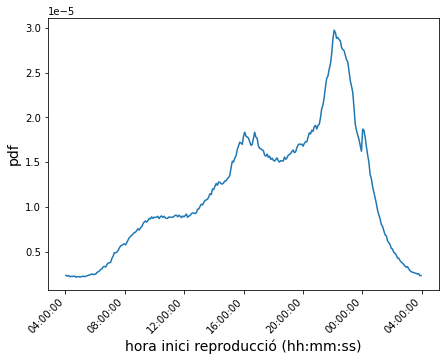

In [11]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['min_data'])-min(df['min_data']))/300.)  # Number of bins (boxes). Every 300s (5min).
hora_inici=df['min_data'].tolist()  
numpy_matrix = np.array(hora_inici)  # List of hora_inici to array
counts_agregat,bin_edges = np.histogram(numpy_matrix,bins,density=True)   # Obtain frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   # Center of each bin


# we need to do this step to undo the 4 hour time shift for visualisation (adding 4h, i.e. 14400 seconds)
bin_centres_shift_agregat=[]   
for i in range(len(bin_centres)):
    bin_centres_shift_agregat.append(bin_centres[i]+14400)
    
    
ax1.plot(bin_centres_shift_agregat, counts_agregat, '-', label='data')    # plot pdf 
ax1.set_xlabel('hora inici reproducció (hh:mm:ss)',fontsize=14)  # labels
ax1.set_ylabel('pdf',fontsize=14)
#ax1.set_yscale('log',basey=10)   # logscale
#ax1.set_xscale('log',basex=10)


# Change the x-axis. From total seconds to the hour of the day
major_ticks = np.arange(14400, 100801, 14400)
#major_ticks = np.arange(0, 86401, 14400)

ax1.set_xticks(major_ticks)

locs, labels=plt.xticks()
new_xticks=[]
for i in locs:
    ty_res = time.gmtime(i)
    res = time.strftime("%H:%M:%S",ty_res)
    new_xticks.append(res)
    
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')


plt.show()

## 1.2- Durada del consum

    - Valor mig i desviació estàndard de les duracions dels consums
    - Pdf en escala semi-log i amb inset log-log
    - Pdf escala normal
    - Ddf (decumulative) en escala log-log
    - Utilitzem bins d'un minut (60s).

In [13]:
durada_consum=df['durada_consum'].tolist()   # consumption duration to list

mean = sum(durada_consum)/len(durada_consum)  # mean value and standard deviation
variance = sum([((x - mean) ** 2) for x in durada_consum]) / len(durada_consum)
stddev = variance ** 0.5     

ty_res = time.gmtime(mean)  # from total seconds to HH:MM:SS format
res = time.strftime("%H:%M:%S",ty_res)
ty_res2 = time.gmtime(stddev)
res2 = time.strftime("%H:%M:%S",ty_res2)

print('Valor mig de la durada del consum: <d>=', mean, 's', '', '=>', '', res)
print('Desviació estàndard: sigma=', stddev, 's', '', '=>', '', res2)

Valor mig de la durada del consum: <d>= 1288.9360753883802 s  =>  00:21:28
Desviació estàndard: sigma= 2980.405043606321 s  =>  00:49:40


<ipython-input-17-b28c2421397d>:18: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-17-b28c2421397d>:23: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_yscale('log',basey=10)
<ipython-input-17-b28c2421397d>:24: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_xscale('log',basex=10)
<ipython-input-17-b28c2421397d>:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axins2.set_xlim(-1000,30000)


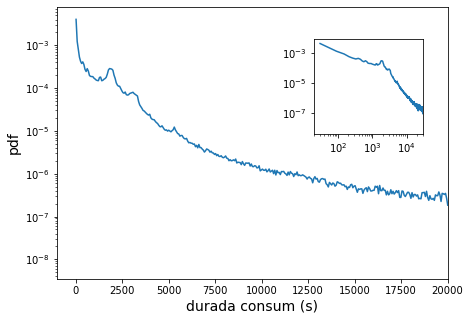

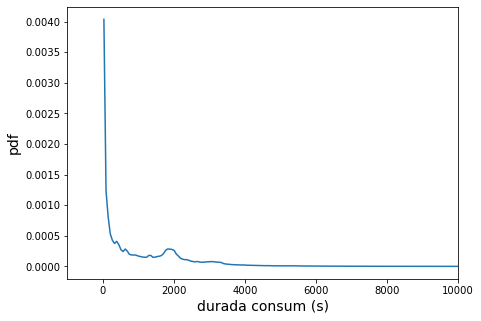

<ipython-input-17-b28c2421397d>:75: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-17-b28c2421397d>:76: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


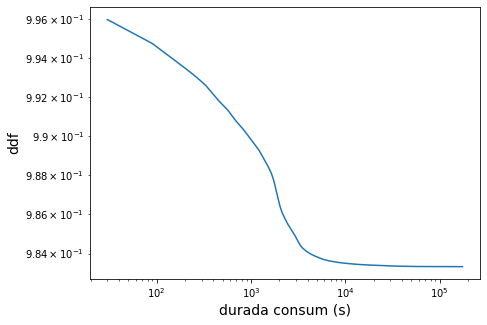

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### SEMI-LOG WITH INSET LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['durada_consum'])-min(df['durada_consum']))/60.)   # bins of 1 minute.
durada_consum=df['durada_consum'].tolist()
numpy_matrix = np.array(durada_consum)  #list to array
counts_consum,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres_consum = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center



ax1.plot(bin_centres_consum, counts_consum, '-', label='data')    #plot pdf
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-1000,20000)
axins2 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,1-0.45,.35,.35), bbox_transform=ax1.transAxes)
axins2.plot(bin_centres_consum, counts_consum, '-')
axins2.set_yscale('log',basey=10)
axins2.set_xscale('log',basex=10)
axins2.set_xlim(-1000,30000)
plt.show()



#########################################################################



#### LINEAR SCALE

fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['durada_consum'])-min(df['durada_consum']))/60.)
durada_consum=df['durada_consum'].tolist()
numpy_matrix = np.array(durada_consum)  #list to array
counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

pdf=counts/sum(counts)

ax1.plot(bin_centres, counts, '-', label='data')    #plot pdf
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
#ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-1000,10000)
plt.show()




#########################################################################

#### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['durada_consum'])-min(df['durada_consum']))/60.)
durada_consum=df['durada_consum'].tolist()
numpy_matrix = np.array(durada_consum)  #list to array
counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

cdf = np.cumsum(counts)
dcdf=1-cdf

ax1.plot(bin_centres, dcdf, '-', label='data')    #plot pdf
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('ddf',fontsize=14)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
#ax1.set_xlim(-100,4000)
plt.show()

## 1.3- Durada del videoclip

    - Valor mig i desviació estàndard de les duracions dels consums
    - Pdf en escala lineal i amb inset log-log
    - Ddf (decumulative) en escala log-log
    - Utilitzem bins d'un minut (60s).

In [20]:
durada_videoclip=df['durada'].tolist()

mean = sum(durada_videoclip)/len(durada_videoclip)  # mean value and std
variance = sum([((x - mean) ** 2) for x in durada_videoclip]) / len(durada_videoclip)
stddev = variance ** 0.5     

ty_res = time.gmtime(mean)  # toformat HH:MM:SS
res = time.strftime("%H:%M:%S",ty_res)
ty_res2 = time.gmtime(stddev)
res2 = time.strftime("%H:%M:%S",ty_res2)

print('Valor mig de la durada: <d>=', mean, 's','', '=>', '', res)
print('Desviació estàndard: sigma=', stddev, 's','', '=>', '', res2)

Valor mig de la durada: <d>= 2422.884191680986 s  =>  00:40:22
Desviació estàndard: sigma= 2480.320525335294 s  =>  00:41:20


<ipython-input-23-bb14f950a151>:21: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_yscale('log',basey=10)
<ipython-input-23-bb14f950a151>:22: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_xscale('log',basex=10)
<ipython-input-23-bb14f950a151>:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axins2.set_xlim(-500,15000)


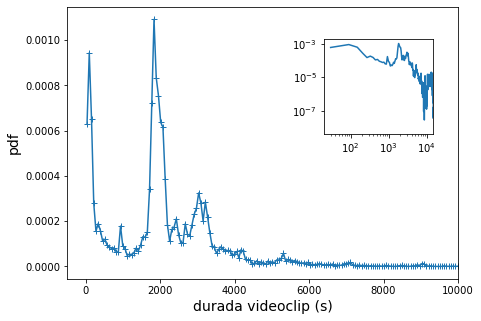

<ipython-input-23-bb14f950a151>:48: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-23-bb14f950a151>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


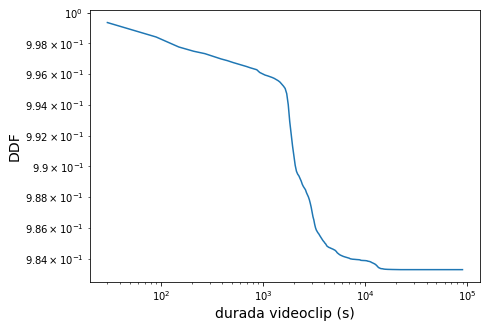

In [23]:
###LINEAR SCALE WITH INSET LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

durada=df['durada'].tolist()
bins=int((max(df['durada'])-min(df['durada']))/60.)
numpy_matrix = np.array(durada)  #list to array
counts_durada,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres_durada = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center


ax1.plot(bin_centres_durada, counts_durada, '-+', label='data')    #plot pdf
ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
#ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-500,10000)

axins2 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,1-0.45,.35,.35), bbox_transform=ax1.transAxes)
axins2.plot(bin_centres_durada, counts_durada, '-')
axins2.set_yscale('log',basey=10)
axins2.set_xscale('log',basex=10)
axins2.set_xlim(-500,15000)


plt.show()




##########################################################

### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

durada=df['durada'].tolist()
numpy_matrix = np.array(durada)  #list to array
counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

cdf = np.cumsum(counts)
dcdf=1-cdf

ax1.plot(bin_centres, dcdf, '-', label='data')    #plot pdf
ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('DDF',fontsize=14)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
#ax1.set_ylim(0.000000001,10)
plt.show()


## 1.4- Usuaris registrats

Hi ha usuaris amb més de 1.000 interaccions (un amb 6.000 i alguns amb 2-3.000) i usuaris amb 1 sola interacció. Molt dispers

In [53]:
print('el promig de registres per usuari és:', (len(df['usuari_id']))/(len(df['usuari_id'].unique())))

el promig de registres per usuari és: 10.915894985935616


In [55]:
df['usuari_id'].value_counts()

76461ea0c45211e9a05d93580548d25d    6344
d67c03101d1d11eaaad0dd0a42997348    3790
66ac49a0414711e7a2ba2966b3ffede4    3368
82c79b90205511ea8a742978692e52e2    2611
fb154300991f11e7a7f1a7b331426ccd    2545
                                    ... 
1b93ef90b93411eb8f76659b7c132db7       1
58f6be40157311eb9bc56b6c55eef539       1
04fcdc20d99b11ea86821dc1e093be20       1
9fdc2f707fac11e88efe4d0e2a3689df       1
04cd19f04f1511ebbbbf7775c6742a70       1
Name: usuari_id, Length: 223970, dtype: int64

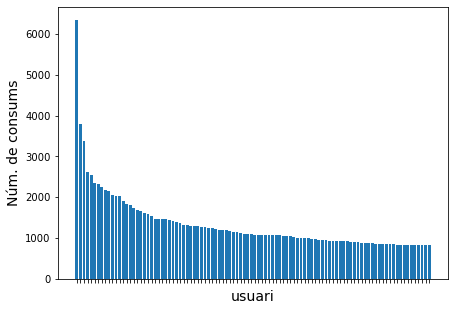

 mitjana nombre registres per usuari: 10.915894985935616
desviació estàndard: 47.632408596026735


In [54]:
values = df['usuari_id'].value_counts().keys().tolist()  
counts = df['usuari_id'].value_counts().tolist()


fig, ax1 = plt.subplots(figsize=(7,5)) 

ax1.bar(values[:100], counts[:100])    #plot the 100 most frequent users.
ax1.set_xlabel('usuari',fontsize=14)
ax1.set_ylabel('Núm. de consums',fontsize=14)
ax1.set(xticklabels=[])

plt.show()

mean = sum(counts)/len(counts)   # mean and std
variance = sum([((x - mean) ** 2) for x in counts]) / len(counts)
stddev = variance ** 0.5

print(' mitjana nombre registres per usuari:', mean)
print('desviació estàndard:',stddev)

## 1.5- Dimensions discretes: dispositiu, programa, dia, mes...

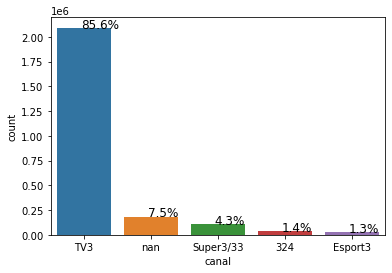

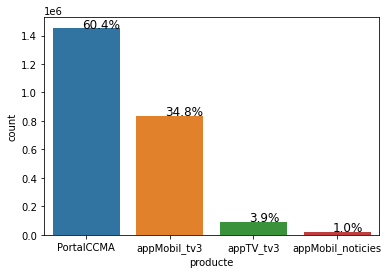

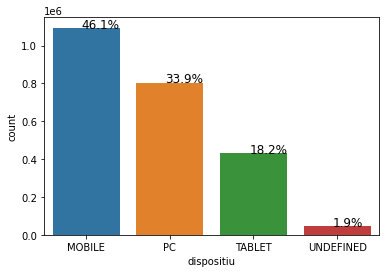

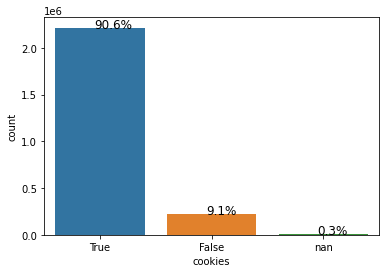

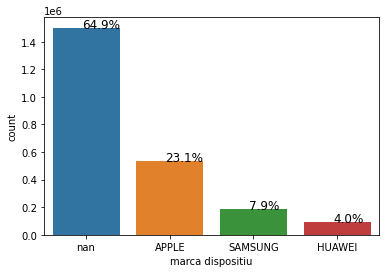

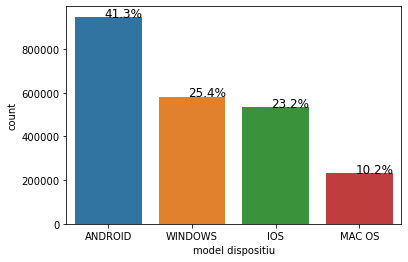

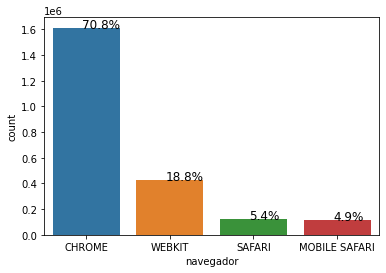

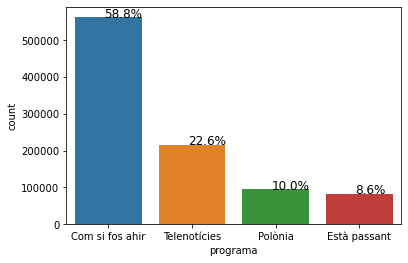

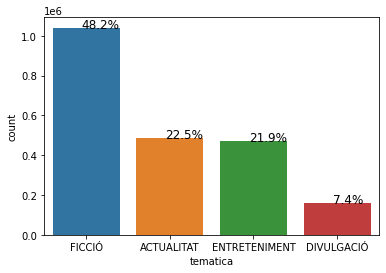

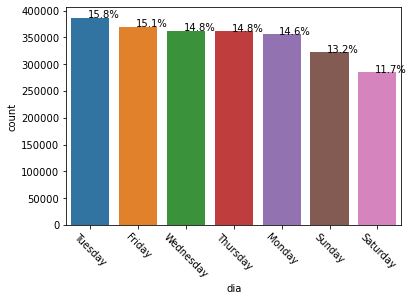

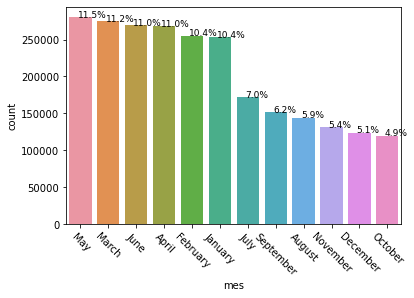

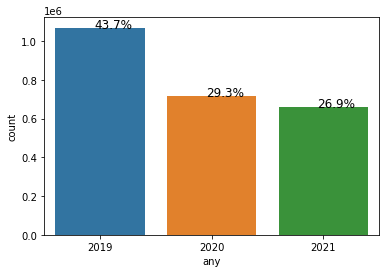

In [39]:
# NOM DEL CANAL
ax = sns.countplot(x=df['canal_nom'], data=df['canal_nom'],order = df['canal_nom'].value_counts().index)
plt.xlabel('canal')
plt.ylabel('count')

total = sum(df['canal_nom'].value_counts())

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.1
    ax.annotate(percentage, (x, y), size = 12)
plt.show()


##############################################

# PRODUCTE CONSUMIT
ax = sns.countplot(x=df['producte_id'], data=df['producte_id'],order = df['producte_id'].value_counts().iloc[:4].index)
plt.xlabel('producte')
plt.ylabel('count')

total = sum(df['producte_id'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

plt.show()




##############################################

# DISPOSITIU UTILITZAT
ax = sns.countplot(x=df['dispositiu_tipus'], data=df['dispositiu_tipus'],order = df['dispositiu_tipus'].value_counts().iloc[:4].index)
plt.xlabel('dispositiu')
plt.ylabel('count')

total = sum(df['dispositiu_tipus'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()




##############################################

# COOKIES
ax = sns.countplot(x=df['dispositiu_accepta_cookies'], data=df['dispositiu_accepta_cookies'],order = df['dispositiu_accepta_cookies'].value_counts().index)
plt.xlabel('cookies')
plt.ylabel('count')

total = sum(df['dispositiu_accepta_cookies'].value_counts())

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()





##############################################

# DISPOSITIU MARCA
ax = sns.countplot(x=df['dispositiu_vendor'], data=df['dispositiu_vendor'],order = df['dispositiu_vendor'].value_counts().iloc[:4].index)
plt.xlabel('marca dispositiu')
plt.ylabel('count')

total = sum(df['dispositiu_vendor'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()




##############################################

# DISPOSITIU MODEL
ax = sns.countplot(x=df['dispositiu_model'], data=df['dispositiu_model'],order = df['dispositiu_model'].value_counts().iloc[:4].index)
plt.xlabel('model dispositiu')
plt.ylabel('count')

total = sum(df['dispositiu_model'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()


##############################################

# NAVEGADOR
ax = sns.countplot(x=df['dispositiu_browser_nom'], data=df['dispositiu_browser_nom'],order = df['dispositiu_browser_nom'].value_counts().iloc[:4].index)
plt.xlabel('navegador')
plt.ylabel('count')

total = sum(df['dispositiu_browser_nom'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()



##############################################

# PROGRAMA
ax = sns.countplot(x=df['programa_nom'], data=df['programa_nom'],order = df['programa_nom'].value_counts().iloc[:4].index)
plt.xlabel('programa')
plt.ylabel('count')

total = sum(df['programa_nom'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()




##############################################

# TEMATICA
ax = sns.countplot(x=df['tematica'], data=df['tematica'],order = df['tematica'].value_counts().iloc[:4].index)
plt.xlabel('tematica')
plt.ylabel('count')

total = sum(df['tematica'].value_counts().iloc[:4])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


plt.show()



##############################################

# DIA
ax = sns.countplot(x=df['day'], data=df['day'],order = df['day'].value_counts().index)
plt.xlabel('dia')
plt.ylabel('count')

total = sum(df['day'].value_counts())

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 10)
    plt.xticks(rotation=315)

plt.show()



##############################################

# MES
ax = sns.countplot(x=df['month'], data=df['month'],order = df['month'].value_counts().index)
plt.xlabel('mes')
plt.ylabel('count')

total = sum(df['month'].value_counts())

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 9)
    plt.xticks(rotation=315)

plt.show()



##############################################

# ANY
ax = sns.countplot(x=df['year'], data=df['year'],order = df['year'].value_counts().index)
plt.xlabel('any')
plt.ylabel('count')

total = sum(df['year'].value_counts())

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.1
    ax.annotate(percentage, (x, y), size = 12)


plt.show()

# 2- RESULTATS DEL CLUSTERING

Utilitzant k=5 clústers, trobem els següents resultats.

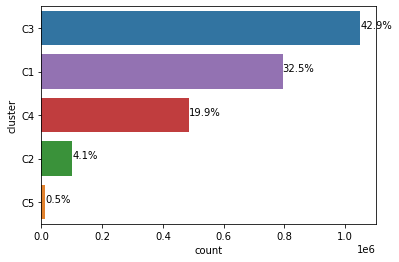

C3    1050006
C1     793958
C4     486972
C2     101415
C5      12482
Name: Segment, dtype: int64

In [25]:
colors=['tab:blue','tab:purple','tab:red','tab:green','tab:orange' ]
ax = sns.countplot(y=df['Segment'], data=df['Segment'],order = df['Segment'].value_counts().index, palette=colors)
plt.xlabel('count')
plt.ylabel('cluster')


total = sum(df['Segment'].value_counts())
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    value=p.get_width()
    x = p.get_x() + p.get_width() + 0.1
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.show()

df['Segment'].value_counts()

## 2.1 - Hora d'inici de la reproducció

C1

count    793958.000000
mean      28926.765013
std       11851.370358
min           0.000000
25%       20128.000000
50%       29982.000000
75%       38903.000000
max       57309.000000
Name: min_data, dtype: float64
C2

count    101415.000000
mean      46185.587941
std       20536.921999
min           2.000000
25%       30345.000000
50%       46639.000000
75%       63436.000000
max       86397.000000
Name: min_data, dtype: float64
C3

count    1.050006e+06
mean     6.265324e+04
std      9.597374e+03
min      3.402800e+04
25%      5.539600e+04
50%      6.375000e+04
75%      6.923700e+04
max      8.639900e+04
Name: min_data, dtype: float64
C4

count    486972.00000
mean      58802.02332
std       11978.52939
min       23221.00000
25%       49344.00000
50%       60078.00000
75%       67885.00000
max       86399.00000
Name: min_data, dtype: float64
C5

count    12482.000000
mean     45668.139160
std      24250.288044
min          7.000000
25%      24715.250000
50%      41582.000000
75% 

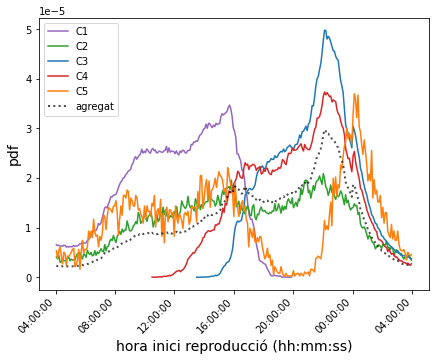

In [27]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

count=0
list_labels=['C1','C2','C3','C4','C5']  
colors=['tab:purple','tab:green','tab:blue','tab:red','tab:orange' ]

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j.min_data.describe())
    
    #fig, ax1 = plt.subplots(figsize=(7,5)) 

    bins=int((max(j['min_data'])-min(j['min_data']))/300.) #bins of 5 minutes.
    hora_inici=j['min_data'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center
     
    bin_centres_shift=[]    # undo 4h shift.
    for p in range(len(bin_centres)):
        bin_centres_shift.append(bin_centres[p]+14400)

    pdf=counts/sum(counts)

    ax1.plot(bin_centres_shift, counts, '-', label=list_labels[count], color=colors[count])    #plot pdf
    
    count=count+1
    
ax1.set_xlabel('hora inici reproducció (hh:mm:ss)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)

major_ticks = np.arange(14400, 100801, 14400)
ax1.set_xticks(major_ticks)

locs, labels=plt.xticks()
new_xticks=[]
for i in locs:
    ty_res = time.gmtime(i)
    res = time.strftime("%H:%M:%S",ty_res)
    new_xticks.append(res)


ax1.plot(bin_centres_shift_agregat, counts_agregat, ':', label='agregat', color='black', linewidth=2,alpha=0.7)

plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')

ax1.legend()

plt.show()



## 2.2- Durada del consum

C1

count    793958.000000
mean       1031.003368
std        1555.277228
min           0.000000
25%          57.000000
50%         386.000000
75%        1650.000000
max       17347.000000
Name: durada_consum, dtype: float64
C2

count    101415.000000
mean       2232.275403
std        3122.583863
min           0.000000
25%         149.000000
50%         881.000000
75%        3029.000000
max       20230.000000
Name: durada_consum, dtype: float64
C3

count    1.050006e+06
mean     1.139956e+03
std      1.427110e+03
min      0.000000e+00
25%      9.300000e+01
50%      6.050000e+02
75%      1.865000e+03
max      1.732600e+04
Name: durada_consum, dtype: float64
C4

count    486972.000000
mean       1028.444621
std        1417.434051
min           0.000000
25%          55.000000
50%         440.000000
75%        1759.000000
max       17390.000000
Name: durada_consum, dtype: float64
C5

count     12482.000000
mean      32726.326791
std       15899.938239
min       16576.000000
25%       21639.

<ipython-input-31-5a802956a21a>:33: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)


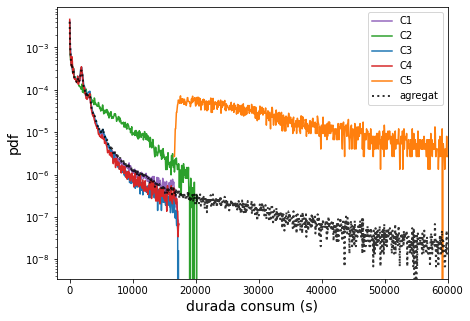

<ipython-input-31-5a802956a21a>:77: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-31-5a802956a21a>:78: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)
<ipython-input-31-5a802956a21a>:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(-2000,80000)


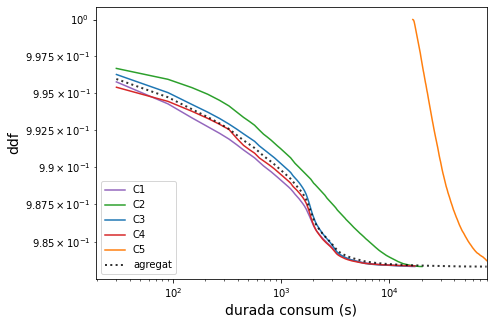

In [31]:
count=0
list_labels=['C1','C2','C3','C4','C5']  
colors=['tab:purple','tab:green','tab:blue','tab:red','tab:orange' ]
    
fig, ax1 = plt.subplots(figsize=(7,5)) 

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j.durada_consum.describe())
        
    #fig, ax1 = plt.subplots(figsize=(7,5)) 

    bins=int((max(j['durada_consum'])-min(j['durada_consum']))/60.) #bins of 1 minute.
    hora_inici=j['durada_consum'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    ax1.plot(bin_centres, counts, '-', label=list_labels[count], color=colors[count])
    
    count=count+1

ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)


ax1.plot(bin_centres_consum, counts_consum, ':', label='agregat', color='black', linewidth=2,alpha=0.8)


ax1.legend()

ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-2000,60000)
plt.show()



count=0
#list_labels=['Second','First','Fifth','Third','Fourth']



############################################################

### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

for i,j in df.groupby('Segment'):
 
    #fig, ax1 = plt.subplots(figsize=(7,5)) 

    bins=int((max(j['durada_consum'])-min(j['durada_consum']))/60.) #bins of 1 minute.
    hora_inici=j['durada_consum'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    cdf = np.cumsum(counts)
    dcdf=1-cdf

    ax1.plot(bin_centres, dcdf, '-', label=list_labels[count], color=colors[count])
    
    count=count+1
    
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('ddf',fontsize=14)

cdf_durada_consum=np.cumsum(counts_consum)
dcdf_durada_consum=1-cdf_durada_consum
ax1.plot(bin_centres_consum, dcdf_durada_consum, ':', label='agregat', color='black', linewidth=2,alpha=0.8)


ax1.legend()
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
ax1.set_xlim(-2000,80000)
plt.show()

## 2.3- Durada del videoclip

C1

count    793958.000000
mean       1834.751036
std        1399.073206
min           0.000000
25%         447.000000
50%        1858.000000
75%        2695.000000
max        8255.000000
Name: durada, dtype: float64
C2

count    101415.000000
mean      12167.927841
std        2334.966699
min        5578.000000
25%       11079.000000
50%       12571.000000
75%       13423.000000
max       89950.000000
Name: durada, dtype: float64
C3

count    1.050006e+06
mean     2.035705e+03
std      1.344042e+03
min      3.000000e+00
25%      1.285000e+03
50%      1.941000e+03
75%      2.847000e+03
max      8.255000e+03
Name: durada, dtype: float64
C4

count    486972.000000
mean       2148.929345
std        1258.457033
min           3.000000
25%        1743.000000
50%        1976.000000
75%        2877.000000
max        8703.000000
Name: durada, dtype: float64
C5

count    12482.000000
mean      3913.651578
std       3328.633005
min          6.000000
25%       1949.000000
50%       2847.000000
75% 

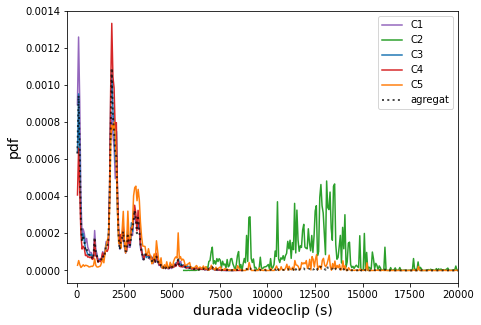

<ipython-input-34-9ebf6260485c>:66: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-34-9ebf6260485c>:67: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


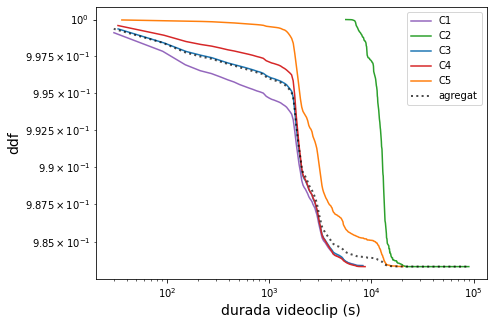

In [34]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

count=0
list_labels=['C1','C2','C3','C4','C5']  
colors=['tab:purple','tab:green','tab:blue','tab:red','tab:orange' ]

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j.durada.describe())
        
    #fig, ax1 = plt.subplots(figsize=(7,5)) 
    
    bins=int((max(j['durada'])-min(j['durada']))/60.)  #1 minute bins.
    hora_inici=j['durada'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    ax1.plot(bin_centres, counts, '-', label=list_labels[count], color=colors[count])
    
    count=count+1

ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
ax1.set_xlim(-500,20000)
#ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)

ax1.plot(bin_centres_durada, counts_durada, ':', label='agregat', color='black', linewidth=2, alpha=0.7)

ax1.legend()

plt.show()


#############################################################

### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

count=0
#list_labels=['Second','First','Fifth','Third','Fourth']

for i,j in df.groupby('Segment'):

    #fig, ax1 = plt.subplots(figsize=(7,5)) 
    
    bins=int((max(j['durada'])-min(j['durada']))/60.) #1 minute bins.
    hora_inici=j['durada'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    cdf = np.cumsum(counts)
    dcdf=1-cdf

    ax1.plot(bin_centres, dcdf, '-', label=list_labels[count], color=colors[count])
    
    count=count+1
    
ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('ddf',fontsize=14)
#ax1.set_xlim(-500,40000)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)

cdf_durada=np.cumsum(counts_durada)
dcdf_durada=1-cdf_durada
ax1.plot(bin_centres_durada, dcdf_durada, ':', label='agregat', color='black', linewidth=2, alpha=0.7)

ax1.legend()
plt.show()

## 2.4- Mes de l'any

C1

March        95063
May          91503
April        86424
June         83333
January      78155
February     69214
July         61131
August       53052
September    51736
November     43935
December     41346
October      39066
Name: month, dtype: int64


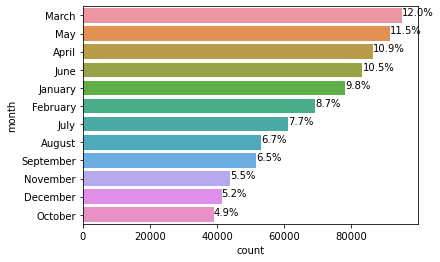

C2

March        15046
February     13417
May          13103
June         12562
April        11772
January       9518
July          5472
September     5371
October       4940
November      4867
December      4462
August         885
Name: month, dtype: int64


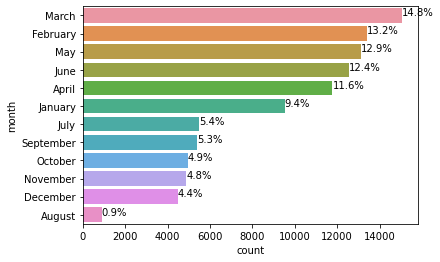

C3

February     124016
May          120326
April        117637
January      115647
March        109240
June          97659
July          73232
September     65434
August        61625
November      57482
December      55160
October       52548
Name: month, dtype: int64


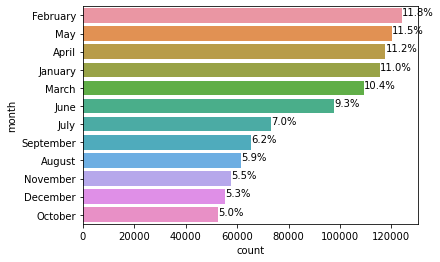

C4

June         75108
May          54806
March        54445
April        51691
January      49043
February     47622
July         31446
September    28102
August       27322
November     23515
October      22089
December     21783
Name: month, dtype: int64


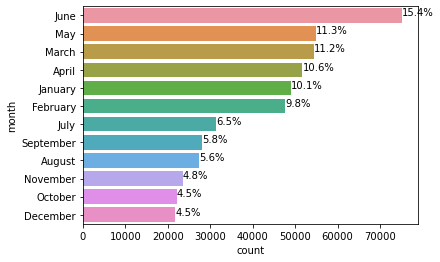

C5

September    1270
February     1179
August       1078
March        1068
November     1063
January      1022
July          990
October       984
December      983
April         979
May           964
June          902
Name: month, dtype: int64


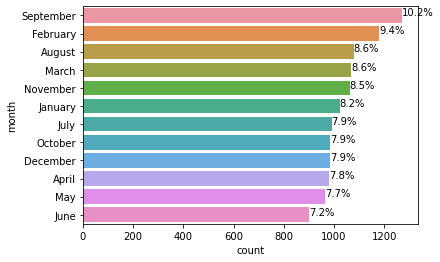

In [5]:
for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j['month'].value_counts())
    
    #plt.figure(figuresize=(7,5))
    #ax=sns.countplot(j['month'].value_counts())
    #j['month'].value_counts().plot(kind='bar')
    #plt.show()
    
    
    ax = sns.countplot(y=j['month'], data=j['month'],order = j['month'].value_counts().index)
    plt.xlabel('count')
    plt.ylabel('month')

    total = sum(j['month'].value_counts())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()

## 2.5- Dia de la setmana

C1

Thursday     127665
Tuesday      122684
Friday       120479
Wednesday    114045
Saturday     111481
Sunday       103703
Monday        93901
Name: day, dtype: int64


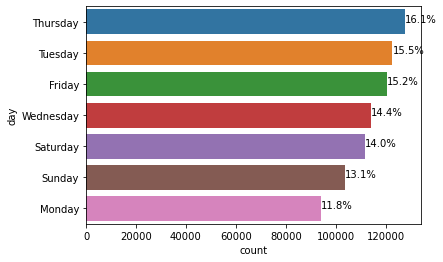

C2

Sunday       35601
Monday       15327
Tuesday      11754
Wednesday    11701
Thursday     10950
Friday        9059
Saturday      7023
Name: day, dtype: int64


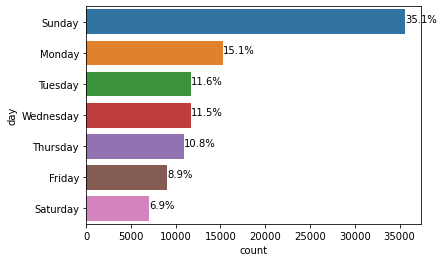

C3

Monday       185888
Tuesday      171887
Wednesday    161354
Thursday     151441
Friday       140598
Sunday       125894
Saturday     112944
Name: day, dtype: int64


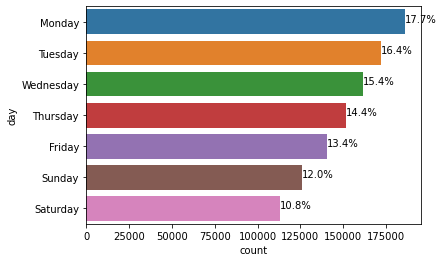

C4

Friday       97841
Tuesday      78770
Wednesday    73963
Thursday     69548
Monday       59669
Sunday       54838
Saturday     52343
Name: day, dtype: int64


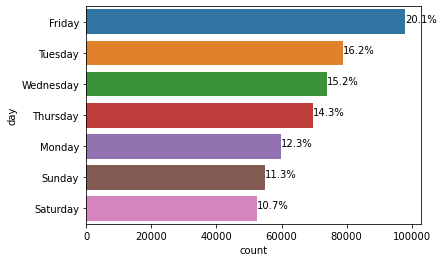

C5

Sunday       2220
Tuesday      1832
Thursday     1793
Wednesday    1720
Friday       1676
Monday       1652
Saturday     1589
Name: day, dtype: int64


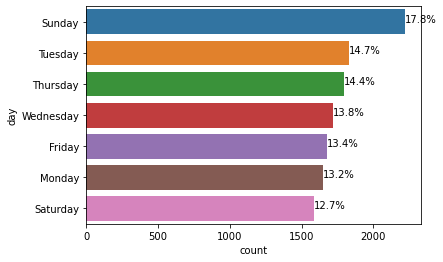

In [6]:
for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j['day'].value_counts())
    
    #plt.figure(figuresize=(7,5))
    #ax=sns.countplot(j['month'].value_counts())
    #j['month'].value_counts().plot(kind='bar')
    #plt.show()
        
    ax = sns.countplot(y=j['day'], data=j['day'],order = j['day'].value_counts().index)
    plt.xlabel('count')
    plt.ylabel('day')

    total = sum(j['day'].value_counts())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()

## 2.6- Any

C1

2019    310368
2020    250538
2021    233052
Name: year, dtype: int64


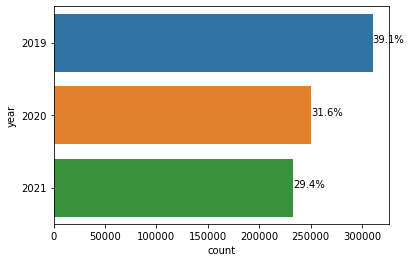

C2

2019    57983
2020    25246
2021    18186
Name: year, dtype: int64


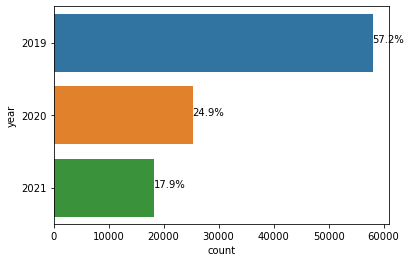

C3

2019    465536
2020    309537
2021    274933
Name: year, dtype: int64


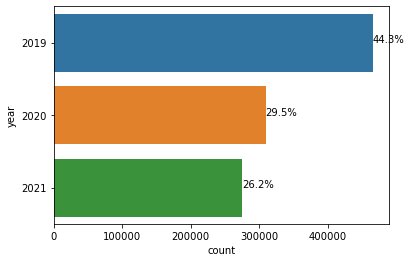

C4

2019    233426
2021    127431
2020    126115
Name: year, dtype: int64


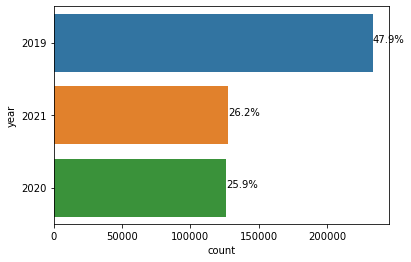

C5

2020    5918
2021    4413
2019    2151
Name: year, dtype: int64


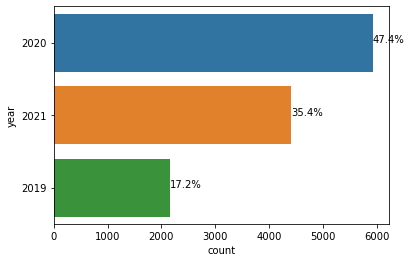

In [7]:
for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j['year'].value_counts())
    
    #plt.figure(figuresize=(7,5))
    #ax=sns.countplot(j['month'].value_counts())
    #j['month'].value_counts().plot(kind='bar')
    #plt.show()
    
    
    ax = sns.countplot(y=j['year'], data=j['year'],order = j['year'].value_counts().index)
    plt.xlabel('count')
    plt.ylabel('year')

    total = sum(j['year'].value_counts())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()

## 2.7- Producte consumit

C1

PortalCCMA           516871
appMobil_tv3         222347
appTV_tv3             30424
appMobil_noticies     10928
appMobil_esport3       8272
HbbTV_tv3              4757
HbbTV_super3            232
appMobil_catradio       116
appMobil_icat             9
appMobil_super3           2
Name: producte_id, dtype: int64


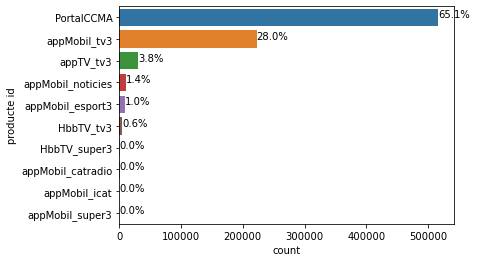

C2

PortalCCMA           63323
appMobil_tv3         35453
appTV_tv3             1737
HbbTV_tv3              543
appMobil_noticies      279
appMobil_esport3        80
Name: producte_id, dtype: int64


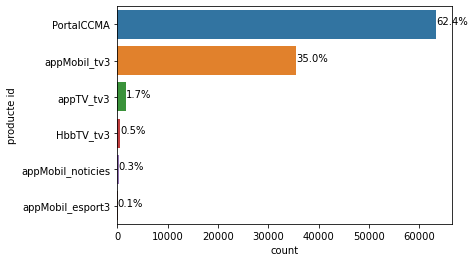

C3

PortalCCMA           779421
appMobil_tv3         215432
appTV_tv3             33165
HbbTV_tv3              8050
appMobil_esport3       7036
appMobil_noticies      6773
HbbTV_super3             85
appMobil_catradio        43
appMobil_icat             1
Name: producte_id, dtype: int64


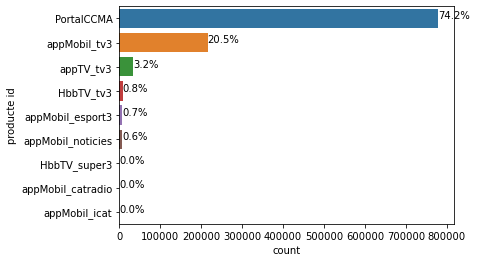

C4

appMobil_tv3         359467
PortalCCMA            86939
appTV_tv3             27947
appMobil_noticies      4991
HbbTV_tv3              4798
appMobil_esport3       2755
appMobil_catradio        68
HbbTV_super3              4
appMobil_icat             3
Name: producte_id, dtype: int64


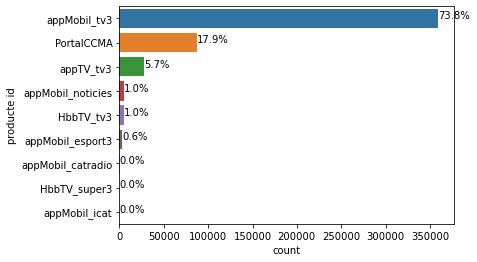

C5

PortalCCMA           7596
appMobil_tv3         4528
appTV_tv3             329
HbbTV_tv3              13
appMobil_noticies      10
appMobil_esport3        4
appMobil_catradio       2
Name: producte_id, dtype: int64


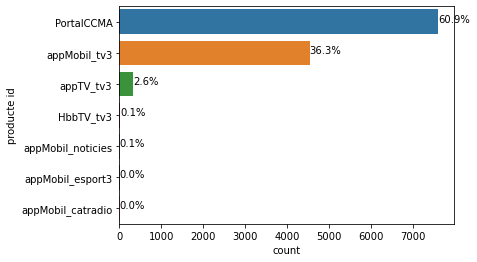

In [8]:
for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j['producte_id'].value_counts())
    
    #plt.figure(figuresize=(7,5))
    #ax=sns.countplot(j['month'].value_counts())
    #j['month'].value_counts().plot(kind='bar')
    #plt.show()
    
    
    ax = sns.countplot(y=j['producte_id'], data=j['producte_id'],order = j['producte_id'].value_counts().index)
    plt.xlabel('count')
    plt.ylabel('producte id')

    total = sum(j['producte_id'].value_counts())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()

## 2.8- Tipus de dispositiu

C1

MOBILE       400415
PC           260334
TABLET        97778
UNDEFINED     13969
TV            12756
SMARTTV        5935
CONSOLE          14
Name: dispositiu_tipus, dtype: int64
793958


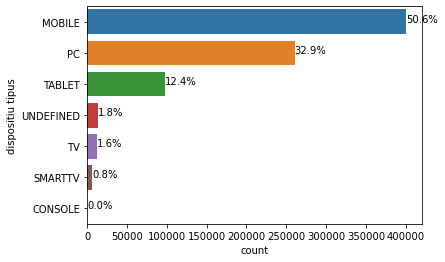

C2

PC           44047
MOBILE       34619
TABLET       18935
UNDEFINED     1943
TV            1010
SMARTTV        607
Name: dispositiu_tipus, dtype: int64
101415


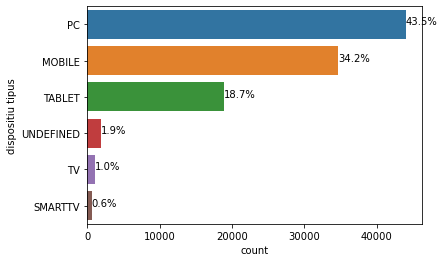

C3

PC           494190
MOBILE       391180
TABLET       107069
UNDEFINED     27404
TV            16384
SMARTTV       10555
CONSOLE          13
Name: dispositiu_tipus, dtype: int64
1050006


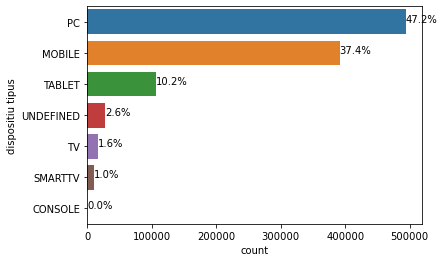

C4

MOBILE       264885
TABLET       203594
TV            12907
SMARTTV        4476
UNDEFINED       708
PC               27
CONSOLE           7
Name: dispositiu_tipus, dtype: int64
486972


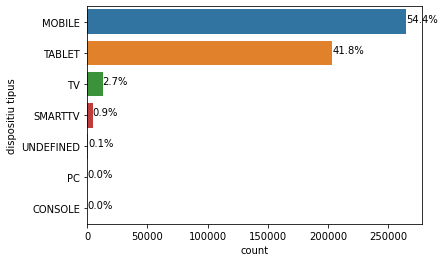

C5

PC           5739
TABLET       3689
MOBILE       2873
TV            100
SMARTTV        20
UNDEFINED      18
Name: dispositiu_tipus, dtype: int64
12482


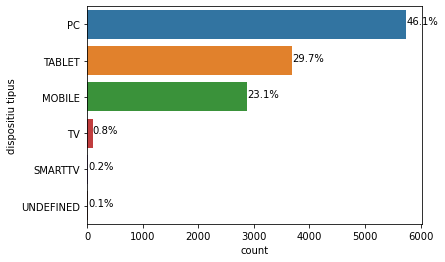

In [9]:
for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j['dispositiu_tipus'].value_counts())
    
    #plt.figure(figuresize=(7,5))
    #ax=sns.countplot(j['month'].value_counts())
    #j['month'].value_counts().plot(kind='bar')
    #plt.show()
    
    print(len(j['dispositiu_tipus']))
    ax = sns.countplot(y=j['dispositiu_tipus'], data=j['dispositiu_tipus'],order = j['dispositiu_tipus'].value_counts().index)
    plt.xlabel('count')
    plt.ylabel('dispositiu tipus')

    total = sum(j['dispositiu_tipus'].value_counts())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()

## 2.9- Canal

C1

TV3          659926
Super3/33     39570
Esport3       13094
324            7300
Name: canal_nom, dtype: int64


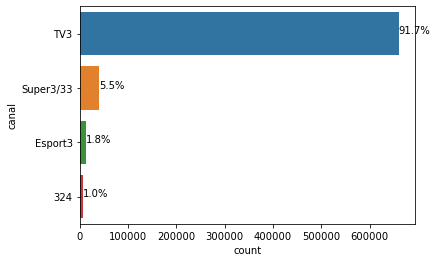

C2

TV3          86998
324          11084
Esport3       1691
Super3/33      626
Name: canal_nom, dtype: int64


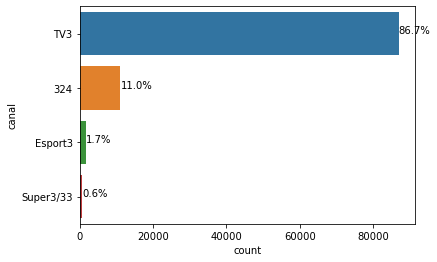

C3

TV3          901652
Super3/33     45469
Esport3       11904
324            8891
Name: canal_nom, dtype: int64


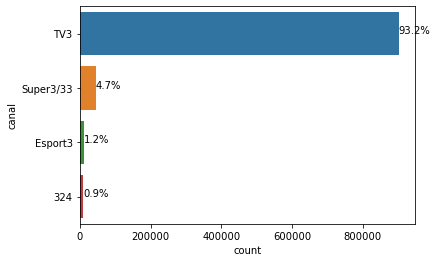

C4

TV3          432997
Super3/33     18018
324            6463
Esport3        3961
Name: canal_nom, dtype: int64


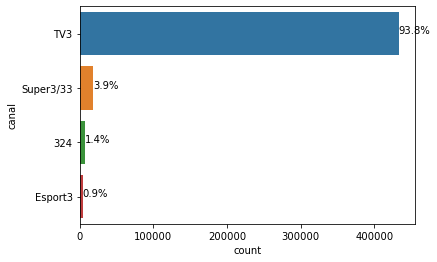

C5

TV3          10882
Super3/33      549
Esport3        140
324             11
Name: canal_nom, dtype: int64


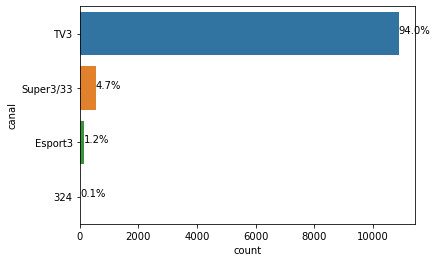

In [10]:
for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j['canal_nom'].value_counts())
    
    #plt.figure(figuresize=(7,5))
    #ax=sns.countplot(j['month'].value_counts())
    #j['month'].value_counts().plot(kind='bar')
    #plt.show()
    
    
    ax = sns.countplot(y=j['canal_nom'], data=j['canal_nom'],order = j['canal_nom'].value_counts().index)
    plt.xlabel('count')
    plt.ylabel('canal')

    total = sum(j['canal_nom'].value_counts())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()

## 2.10- Valors únics en cada clúster

Es pot utilitzar qualsevol dimensió on "dipositiu_vendor". Mostra quantes categòries úniques hi ha a cada clúster. Serveix per veure com de heterogeni és cada clúster per una dimensió concreta. 

Per exemple, hi ha 71 marques de dispostius i observem que en el clúster 1 hi ha 61 marques diferents, per la qual cosa el C1 és molt heterogeni en quant a marques de dispositiu. En canvi el C5 és més homogèni. 

Cal tenir en compte que depèn també de la mida del cúster. Degut a que el clúster 5 és molt petit (0.7%) comparat amb el 32.5% del C1, sembla evident que per estadística i haurà més heterogeneïtat en el C1.

In [16]:

result = df.groupby('Segment')['dispositiu_vendor'].nunique()

print(result)

Segment
C1    67
C2    40
C3    58
C4    53
C5    23
Name: dispositiu_vendor, dtype: int64


## 2.11- Evolució dels clústers per any

També podem veure com canvien les mides del clúster a cada any (2019, 2020, 2021). Representem aquestes mides (normalitzades) en una gràfica apilada de barres. Observem que es mantenen constants al llarg del temps

<AxesSubplot:>

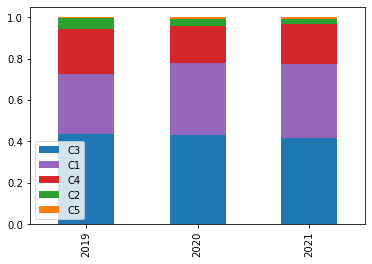

In [36]:
# Count occurrences in each cluster for every year
year_2019 = (df.loc[df['year']=='2019']['Segment'].value_counts())/len(df.loc[df['year']=='2019'])
year_2020 = df.loc[df['year']=='2020']['Segment'].value_counts()/len(df.loc[df['year']=='2020'])
year_2021 = df.loc[df['year']=='2021']['Segment'].value_counts()/len(df.loc[df['year']=='2021'])

df_plot  = pd.DataFrame([year_2019,year_2020,year_2021])
df_plot.index=['2019','2020','2021']

# Bar plot
colors=['tab:blue','tab:purple','tab:red','tab:green','tab:orange' ]
df_plot.plot(kind='bar',stacked=True, color=colors)

# 3- Cross validation score i SHAP Value. LightGBM (machine learning)

Utilitzem un algoritme classificador de Machine Learning, anomenat LIGHT GBM, que treballa amb dades de tipus mixt. El que fem és agafar una part de les dades (per exemple, 4/5) i utilitzar-les com a "train". El que fa el model és aprendre i entrenar les dades en base al clúster al que pertanyen (per exemple, si aquesta unitat de consum té aquests X atributs, pertany al clúster 1, etc). 

Aleshores, l'altre part de les dades (1/5 per ex.) s'utilitza com a "test". El model classificador tracta de predir a quin cluster pertany cadascuna d'aquestes unitats de consum.

El cross-validation score el que fa és mesurar l'encert en la predicció, ja que disposem de les etiquetes reals del clúster. Aleshores, es poden comparar les etiquetes reals amb les predites pel model i mesurar la probabilitat d'encert.

El que es fa amb el cross-validation score, és realitzar totes les permutacions possibles amb els conjunts de dades "train i test" i treu el valor mig d'encert en la predicció. 

Un valor prop del 100% significa que els clústers es poden predir amb facilitat i podem assignar unitats de consum noves a clústers amb molt d'encert. Això vol dir que els clústers són d'alta qualitat, distingibles i significatius.

## 3.1- Cross validation score

In [40]:
df['player_id']=df['player_id'].astype(str)
df['contingut_id']=df['contingut_id'].astype(str)
df['programa_capitol']=df['programa_capitol'].astype(str)

In [44]:
#Setting the objects to category 

lgbm_data = df.copy()
del lgbm_data['Segment']
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [45]:
# Light GBM Classifier.
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import time

start_lgmb=time.time()

clusters=df['Segment'].tolist()    # Cluster labels (C1, C2...)

clf_kp = LGBMClassifier(colsample_bytree=0.8)   # Use LGBM Classifer to train the data and predict the cluster labels
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, cv=5, scoring='f1_weighted',n_jobs=-1)  # CV score

print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

end_lgmb=time.time()
print((end_lgmb-start_lgmb)/60.0, 'minuts')


CV F1 score for K-Prototypes clusters is 0.9778443226850015
4.093719693024953 minuts


## 3.2- SHAP Value

El shap value és un "tree explainer". Agafa les dades de les unitats de consum i les seves etiquetes dels clústers. Passant-li el model classificador de lightGBM, el que fa es "explicar" l'impacte de cada dimensió. En altres paraules, mesura com de rellevant és cada dimensió a l'hora de predir les etiquetes dels clusters.

Per exemple, si treu la dimensió de l'hora d'inici "min_data", quins resultats obté de la predicció de cada clúster? L'arbre va realitzant iteracions anant treien cada dimensió i mesuran l'impacte en cada cluster. D'aquesta manera, un valor alt del SHAP Value d'una dimensió per un determinat clúster vol dir que aquella dimensió té un fort impacte a l'hora de predir (i per tant formar i distingir) aquell clúster.


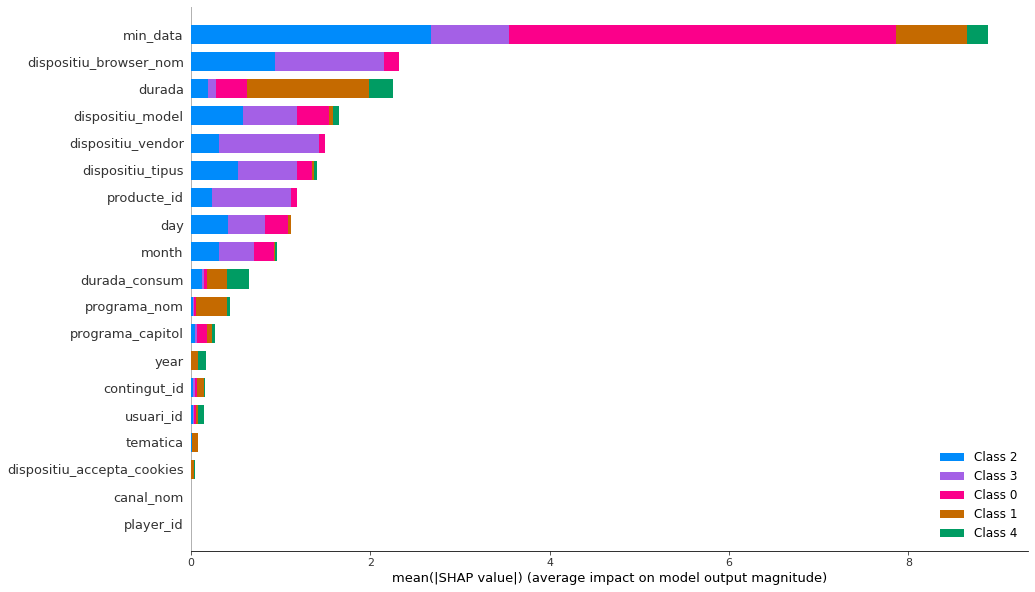

In [46]:
import shap

clf_kp.fit(lgbm_data, clusters)      # Fit the data and cluster labels and use the TreeExplainer and obtain SHAP VALUES
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

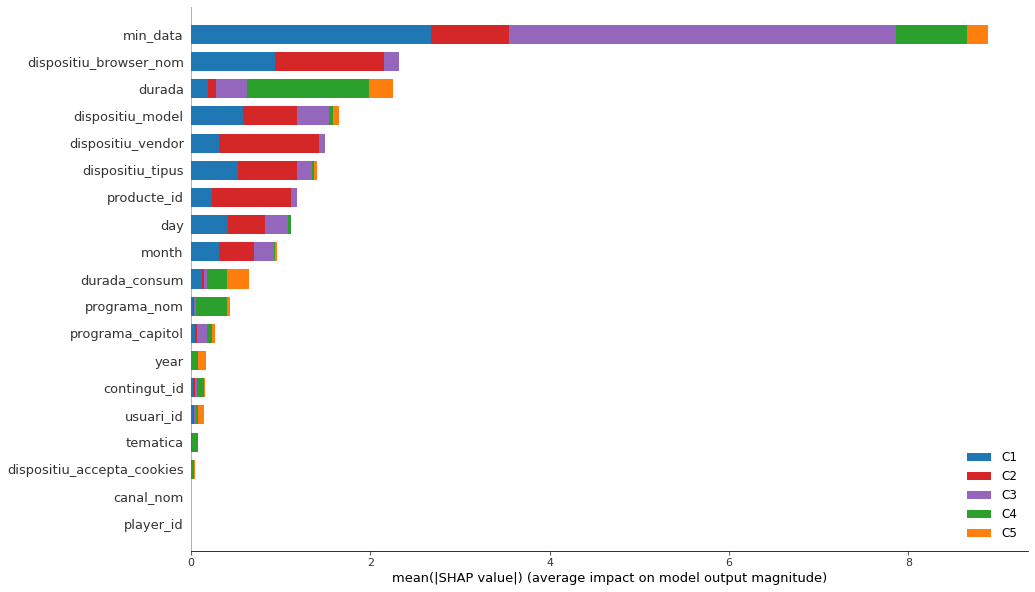

In [49]:
import matplotlib.colors

list_labelss=['C3','C4','C1','C2','C5']   # Change legend and colors to be coherent
colors=['tab:blue','tab:red','tab:purple','tab:green','tab:orange' ]

cmap = matplotlib.colors.ListedColormap(colors)

shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10),color=cmap, class_names=list_labelss)